<a href="https://colab.research.google.com/github/437-maral/Deap-Learning-/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from typing import List, Callable, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [8]:
lblock = torch.tensor([[0.,0.], [1.,0.], [2.,0.], [0.,1.], [1.,1.], [2.,1.], [1.,2.], [2.,2.], [1.,3.], [2.,3.]])
square = torch.tensor([[0.,0.], [1.,0.], [2.,0.], [0.,1.], [1.,1.], [2.,1.], [0.,2.], [1.,2.], [2.,2.]])
line = torch.tensor([[0.,0.], [1.,0.], [2.,0.], [3.,0.], [4.,0.], [0.,1.], [1.,1.], [2.,1.], [3.,1.], [4.,1.]])
step = torch.tensor([[0.,0.], [1.,0.], [2.,0.], [0.,1.], [1.,1.], [2.,1.], [3.,1.], [1.,2.], [2.,2.], [3.,2.]])
tblock = torch.tensor([[0.,0.], [1.,0.], [2.,0.], [3.,0.], [0.,1.], [1.,1.], [2.,1.], [3.,1.], [1.,2.], [2.,2.]])
tetris_blocks = [lblock, square, line, step, tblock]

torch.Size([10, 2])

In [24]:
def compute_edges(points:torch.FloatTensor, cutoff:float=1.) -> torch.LongTensor:
    """
    This function computes the edges of graph given an array of nodes with 2d coordinates.
    The graph will we created by connecting all nodes with an euclidean distance smaller or equal
    than the provided cutoff.

    Args:
    - points: tensor of coordinates with shape (num_nodes x 2)
    - cutoff: cutoff distance to determine whether two points are connected in the graph.

    Returns:
    - edges: tensor of shape [num_edges x 2] where each row corresponds to the indices of the 
      connected nodes (incoming, outgoing)

    """

    edges = torch.Tensor()
    for i, node1 in enumerate(points): 
        # inner loop over possible neighbors
        for j, node2 in enumerate(points):

            # check cutoff
            if  torch.sqrt((node1[0]-node2[0])**2 + (node1[1]-node2[1])**2) <= cutoff: ###since we have 2d array
                new_edges = torch.Tensor([[i, j], [j, i]])
                edges = torch.concat((edges, new_edges))
    edges = edges.long()
    return edges  

    

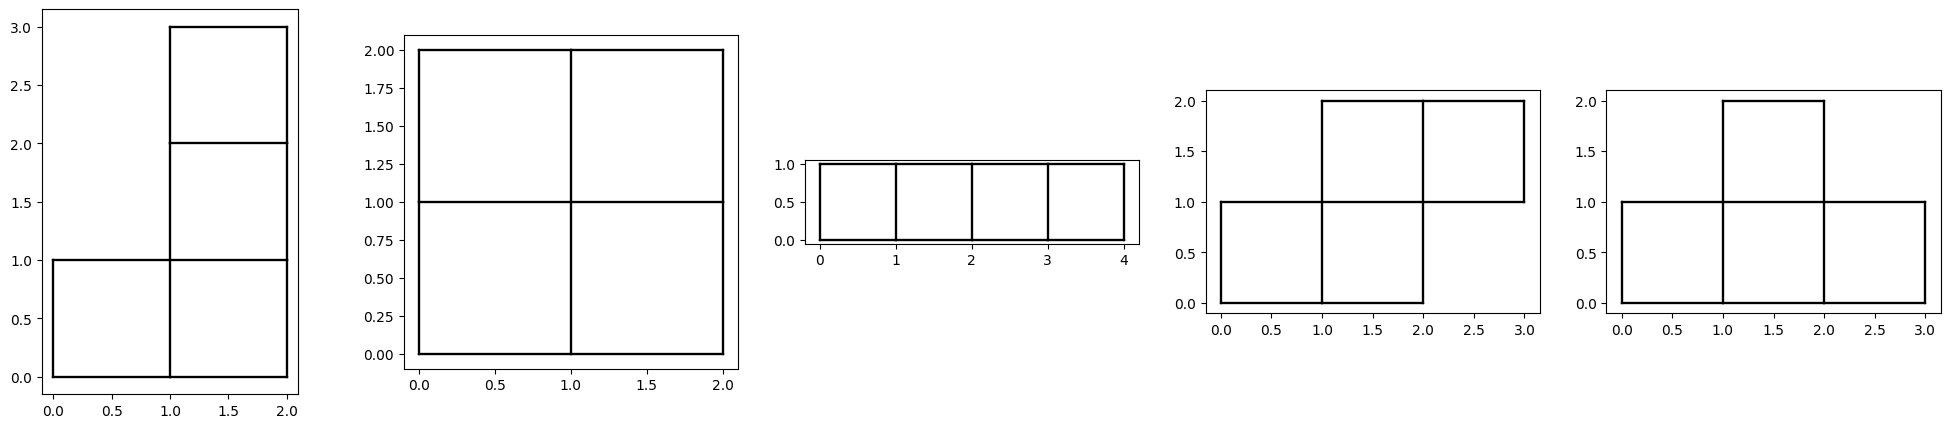

tensor([0, 0, 0, 0, 0, 1, 1, 0, 0, 4, 4, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 1,
        1, 5, 5, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 6, 6, 2, 3, 2, 2, 3,
        3, 3, 3, 3, 3, 7, 7, 3, 4, 0, 0, 4, 4, 4, 4, 4, 4, 5, 5, 4, 5, 1, 1, 5,
        5, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 8, 8, 5, 6, 2, 2, 6, 6, 5, 5, 6,
        6, 6, 6, 6, 6, 7, 7, 6, 6, 9, 9, 6, 7, 3, 3, 7, 7, 6, 6, 7, 7, 7, 7, 7,
        8, 5, 5, 8, 8, 8, 8, 8, 8, 9, 9, 8, 9, 6, 6, 9, 9, 8, 8, 9, 9, 9, 9, 9])

In [65]:
def create_dataset(shuffle:bool=False):
    tetris_edges = []
    tetris_points = []
    for points in tetris_blocks:
        if shuffle:
            sort_idx = torch.randperm(points.shape[0])
            points = points[sort_idx]
        tetris_points.append(points)

        edges = compute_edges(points)
        tetris_edges.append(edges)
    return tetris_points, tetris_edges

tetris_points, tetris_edges = create_dataset(shuffle=False)

plt.figure(figsize=(25, 5))
for i, graph in enumerate(zip(tetris_points, tetris_edges)):
    block, edges = graph
    plt.subplot(1, 5, i+1)
    X = torch.vstack([block[edges[:,0],0], block[edges[:,1], 0]])
    Y = torch.vstack([block[edges[:,0],1], block[edges[:,1], 1]])
    plt.plot(X, Y, c='k')
    plt.gca().set_aspect('equal')

plt.show()


edges.flatten()

In [26]:
def build_batch(edges_list:List[torch.Tensor]) -> Tuple[torch.LongTensor, torch.LongTensor, torch.LongTensor]:
    num_nodes = torch.tensor([torch.max(edges)+1 for edges in edges_list])
    classes = torch.arange(len(tetris_edges), dtype=torch.long)
    block_idx = torch.repeat_interleave(classes, num_nodes)

    # convert node indices to global batch indices
    node_offsets = torch.cumsum(torch.cat([torch.zeros((1,), dtype=torch.long), num_nodes]), 0)
    global_edges_list = [edges + node_offsets[i] for i, edges in enumerate(edges_list)]
    batched_node_labels = torch.ones((torch.sum(num_nodes), 1))
    batched_edges = torch.vstack(global_edges_list)
    return batched_node_labels, batched_edges, block_idx, classes
    
batch = build_batch(tetris_edges)

print(f'batched_node_labels [first 10 entrie]: {batch[0][:10]}')
print(f'batched_edges [first 10 entrie]: {batch[1][:10]}')
print(f'block_idx: {batch[2]}')
print(f'classes: {batch[3]}')

batched_node_labels [first 10 entrie]: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
batched_edges [first 10 entrie]: tensor([[0, 0],
        [0, 0],
        [0, 1],
        [1, 0],
        [0, 3],
        [3, 0],
        [1, 0],
        [0, 1],
        [1, 1],
        [1, 1]])
block_idx: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4])
classes: tensor([0, 1, 2, 3, 4])


In [53]:
from torch._C import Value
def scatter_add(x: torch.Tensor, idx: torch.Tensor, dim_size: int, dim: int = 0) -> torch.Tensor:
    """
    Sum over given indices as described above.

    Args:
    - x: input tensor
    - idx: index tensor
    - dim: dimension along which is summed
    - dim_size: size of the dimension along which is summed in the output tensor

    Returns:
    - summed_x: tensor with shape: x.shape[:dim] + (dim_size,) + x.shape[dim+1:]
    """
    T = torch.zeros(x.shape[:dim] + (dim_size,) + x.shape[dim+1:], dtype=x.dtype)
    summed_x = T.index_add_(dim, idx, x)
    

    return summed_x



# Test
x = torch.tensor(([1,2,3,4], [3,2,4,6]))
idx = torch.tensor([0, 0, 1, 0])

y = scatter_add(x, idx, dim_size=2, dim=1)
print("Result:", y)
print("Expected:", torch.tensor([[ 7,  3], [11,  4]]))

Result: tensor([[ 7,  3],
        [11,  4]])
Expected: tensor([[ 7,  3],
        [11,  4]])


In [29]:
tensor = torch.tensor([1, 2, 3, 4, 5])

# Create an index tensor
index = torch.tensor([0, 2, 4])

# Create a value tensor
values = torch.tensor([10, 20, 30])

# Add values to tensor at specified indices
result = torch.index_add(tensor, dim=0, index=index, source=values)

print(result)

tensor([11,  2, 23,  4, 35])


In [45]:
x = torch.ones(5, 3)
t = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float)
index = torch.tensor([0, 4, 2])
x.index_add_(0, index, t)
x.index_add_(0, index, t, alpha=-1)




tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [68]:
class GraphConv(nn.Module):

    def __init__(self, n_in:int , n_out: int, activation=F.relu):
        super().__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.activation = activation
        self.theta = nn.Parameter(torch.empty((n_in, n_out)))
        torch.nn.init.xavier_uniform_(self.theta)


    def forward(self, x:torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
        messages = self.compute_message(x, edges)

        # aggregate messages for each node
        aggregated_messages = self.aggregate(messages, edges)

        # update node states
        x = self.compute_update(x, aggregated_messages)
        return x

    def aggregate(self, messages:torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
        ## INSERT YOUR SOLUTION HERE

        return scatter_add(messages, edges[:, 0], dim=0, dim_size=edges.max().item() + 1)
        



    def compute_message(self, x:torch.Tensor, edges:torch.Tensor) -> torch.Tensor:
      n_nodes = torch.max(edges) + 1  # Assuming no unconnected nodes
      A = torch.zeros((n_nodes, n_nodes))
      A[edges[:, 0], edges[:, 1]] = 1
      D = torch.diag(torch.sqrt(torch.sum(A, dim=1)))
      L = torch.matmul(torch.matmul(D.inverse(), A), D.inverse())
      messages = torch.matmul(L, x)
      return messages

    def compute_update(self, x:torch.Tensor, m:torch.Tensor) -> torch.Tensor:
        ## INSERT YOUR SOLUTION HERE
        y = torch.mm(m, theta)
        y = activation(y)
        return y